# ImageNet Baseline - Simple ResNet

This notebook implements a simple baseline on ImageNet using a ResNet architecture.


In [1]:
# Global preparations
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:5'
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")


PyTorch version: 2.1.2+cu121
Device: cuda:5


## Data Loading

ImageNet dataset loading with standard augmentations for training and validation.


In [2]:
# ImageNet data paths (adjust these to your ImageNet location)
imagenet_train_path = '/path/to/imagenet/train'  # Update this path
imagenet_val_path = '/path/to/imagenet/val'      # Update this path

# Standard ImageNet normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    normalize,
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# Note: You need to have ImageNet dataset downloaded
# For demonstration, we'll use ImageNet-like dataset or CIFAR-100 as a proxy
# Uncomment and update paths when you have ImageNet available
"""
train_dataset = torchvision.datasets.ImageFolder(
    root=imagenet_train_path,
    transform=train_transform
)

val_dataset = torchvision.datasets.ImageFolder(
    root=imagenet_val_path,
    transform=val_transform
)
"""

# Using CIFAR-100 as a smaller proxy for testing (same structure as ImageNet)
# Replace with ImageNet when available
print("Using CIFAR-100 as a proxy dataset. Replace with ImageNet for full experiments.")

train_transform_cifar = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

val_transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=train_transform_cifar
)

val_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=val_transform_cifar
)

batch_size = 512
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")


Using CIFAR-100 as a proxy dataset. Replace with ImageNet for full experiments.
Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 50000
Val dataset size: 10000
Number of classes: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


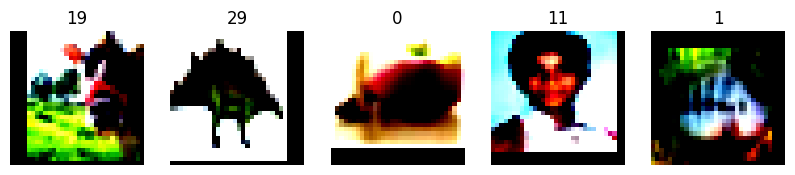

In [3]:
# visualise few samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.title(train_dataset[i][1])
    plt.axis('off')

## Baseline Model

We'll use ResNet18 as a simple baseline. This can be easily replaced with ResNet50 or other architectures.


In [ ]:
# Load pre-trained ResNet18 and modify for our dataset
# For CIFAR-100, we'll modify the first conv layer to handle 32x32 images
# For ImageNet (224x224), use standard ResNet18

num_classes = len(train_dataset.classes)

if hasattr(train_dataset, 'classes'):
    # CIFAR-100 or similar small dataset
    model = torchvision.models.resnet18(weights=None)  # Start from scratch
    # Modify first conv layer for smaller input
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove maxpool for smaller images
    model.fc = nn.Linear(model.fc.in_features, num_classes)
else:
    # ImageNet
    model = torchvision.models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: ResNet18")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Number of classes: {num_classes}")


## Training Setup

Define loss function, optimizer, and learning rate scheduler.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=30,
    gamma=0.1
)

print("Optimizer: SGD with momentum 0.9, weight decay 1e-4")
print("Initial learning rate: 0.1")
print("Scheduler: StepLR (reduce by 0.1 every 30 epochs)")


## Training and Evaluation Functions


In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_description(f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_description(f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


## Training Loop


In [ ]:
num_epochs = 100  # Adjust as needed
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"Starting training for {num_epochs} epochs...")
print(f"Batch size: {batch_size}")
print(f"Device: {device}\n")

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 60)


## Plot Results


In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', color='blue')
ax2.plot(val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(val_accs):.2f}% at epoch {val_accs.index(max(val_accs))+1}")


## LUT-based Vision Transformer (LUTViT)

Adapting SimpleViT to use LUT layers similar to LUTTransformer.


In [6]:
# Import LUTNet components
import sys
import os
sys.path.insert(0, os.path.expanduser('~/spiky'))

from spiky.lut.LUTLayer import (
    Conv2DLUTLayer, LUTLayer, LUTSharedContext, SynapseMeta, GradientPolicy, GradientType
)
from spiky.util.torch_utils import make_lr_getter

# Setup LUTNet shared context and metadata
summation_dtype = torch.float32

synapse_meta = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=0.0,
    initial_noise_level=0.0
)

shared_lut_ctx = LUTSharedContext()
shared_lut_ctx.to_device(device)
g_policy = GradientPolicy(GradientType.Dense, normalized=False)

print("LUTNet components initialized")

LUTNet components initialized


In [11]:
# LUT-based Vision Transformer adapted from SimpleViT
class LUTViT(nn.Module):
    def __init__(self, image_size=32, patch_size=4, in_chans=3,
                 num_classes=100, dim=32, depth=6, num_heads=8, 
                 n_detectors=128, n_anchors_per_detector=10, 
                 n_anchors_per_detector_attention=None,
                 dropout=0.1, use_batch_norm=False,
                 device=None, _synapse_meta=None, 
                 lut_shared_context=None, seed=None, 
                 summation_dtype=torch.float32):
        super().__init__()
        
        assert image_size % patch_size == 0
        n_patches = (image_size // patch_size) ** 2
        patch_dim = in_chans * patch_size * patch_size
        
        self.image_size = image_size
        self.patch_size = patch_size
        self.n_patches = n_patches
        self.dim = dim
        self.depth = depth
        self.num_heads = num_heads
        
        if device is None:
            device = torch.device('cpu')
        self.device = device
        
        if _synapse_meta is None:
            _synapse_meta = SynapseMeta(
                min_weight=-1.0,
                max_weight=1.0,
                initial_weight=0.0,
                initial_noise_level=0.0
            )
        
        if lut_shared_context is None:
            lut_shared_context = LUTSharedContext()
            lut_shared_context.to_device(device)
        
        self.lut_shared_context = lut_shared_context
        self.weights_gradient_policy = g_policy
        
        # Patch embedding: linear layer to embed patches
        self.patch_to_emb = nn.Linear(patch_dim, dim, device=device)
        
        # CLS token and positional embeddings
        self.cls = nn.Parameter(torch.zeros(1, 1, dim, device=device))
        self.pos_drop = nn.Dropout(dropout)
        
        # Initialize CLS and positional embeddings
        nn.init.trunc_normal_(self.cls, std=0.02)
        
        # Transformer blocks
        self.blocks = nn.ModuleList()
        n_anchors_attn = n_anchors_per_detector_attention if n_anchors_per_detector_attention is not None else n_anchors_per_detector
        
        for layer_idx in range(depth):
            block = nn.ModuleDict()
            
            # Multi-head attention using LUTLayer
            # Use a single LUTLayer for attention (similar to LUTTransformer)
            # The LUTLayer processes the sequence with sequence_length = 1 + n_patches
            block['attention_lut'] = LUTLayer(
                n_inputs=dim,
                n_outputs=dim,
                positional_dim=dim,
                concatenation_product=False,
                n_detectors=n_detectors * num_heads,  # Scale detectors for multi-head capacity
                n_anchors_per_detector=n_anchors_attn,
                sequence_length=1 + n_patches,  # CLS + patches
                synapse_meta=_synapse_meta,
                weights_gradient_policy=self.weights_gradient_policy,
                shared_context=self.lut_shared_context,
                summation_dtype=summation_dtype,
                random_seed=None if seed is None else seed + layer_idx * num_heads,
                device=device
            )
            block['attention_dropout'] = nn.Dropout(dropout)
            
            if use_batch_norm:
                block['attention_bn'] = nn.BatchNorm1d(dim, device=device)
            else:
                block['attention_bn'] = None
            
            # FFN using LUTLayer
            # FFN processes each token independently (sequence_length=1)
            block['ffn'] = LUTLayer(
                n_inputs=dim,
                n_outputs=dim,
                n_detectors=n_detectors,
                n_anchors_per_detector=n_anchors_per_detector,
                sequence_length=1,  # Process tokens independently
                synapse_meta=_synapse_meta,
                weights_gradient_policy=self.weights_gradient_policy,
                shared_context=self.lut_shared_context,
                summation_dtype=summation_dtype,
                random_seed=None if seed is None else seed + layer_idx * num_heads + num_heads,
                device=device
            )
            block['ffn_dropout'] = nn.Dropout(dropout)
            
            if use_batch_norm:
                block['ffn_bn'] = nn.BatchNorm1d(dim, device=device)
            else:
                block['ffn_bn'] = None
            
            self.blocks.append(block)
        
        # Final normalization and classification head
        self.norm = nn.LayerNorm(dim, device=device)
        self.head = LUTLayer(
            n_inputs=dim,
            n_outputs=num_classes,
            n_detectors=n_detectors,
            n_anchors_per_detector=n_anchors_per_detector,
            sequence_length=1,
            synapse_meta=_synapse_meta,
            weights_gradient_policy=self.weights_gradient_policy,
            shared_context=self.lut_shared_context,
            summation_dtype=summation_dtype,
            random_seed=seed,
            device=device
        )
    
    def forward(self, x):
        B, C, H, W = x.shape
        P = self.patch_size
        
        # Patch embedding: (B, C, H, W) -> (B, N, patch_dim) -> (B, N, dim)
        x = x.unfold(2, P, P).unfold(3, P, P)  # (B, C, Hp, Wp, P, P)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()  # (B, Hp, Wp, C, P, P)
        x = x.view(B, -1, C * P * P)  # (B, N, patch_dim)
        x = self.patch_to_emb(x)  # (B, N, dim)
        
        # Add CLS token
        cls_tokens = self.cls.expand(B, -1, -1)  # (B, 1, dim)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 1+N, dim)
        x = self.pos_drop(x)
        
        # Transformer blocks
        for block in self.blocks:
            residual = x
            
            # Multi-head attention using LUTLayer
            # LUTLayer processes sequence: (B, 1+N, dim) -> (B, 1+N, dim)
            # The sequence_length=1+N means it processes the whole sequence
            attn_out = block['attention_lut'](x)  # (B, 1+N, dim)
            attn_out = block['attention_dropout'](attn_out)
            
            if block['attention_bn'] is not None:
                # BatchNorm: (B, 1+N, dim) -> (B*(1+N), dim) -> (B, 1+N, dim)
                attn_out_flat = attn_out.reshape(-1, self.dim)
                attn_out_flat = block['attention_bn'](attn_out_flat)
                attn_out = attn_out_flat.reshape(B, 1 + self.n_patches, self.dim)
            
            x = residual + attn_out  # Residual connection
            
            # FFN with residual connection
            residual = x
            # Reshape for FFN: (B, 1+N, dim) -> (B*(1+N), 1, dim) for sequence_length=1
            non_seq_shape = (B * (1 + self.n_patches), 1, self.dim)
            seq_shape = (B, 1 + self.n_patches, self.dim)
            ffn_out = block['ffn'](x.reshape(non_seq_shape))  # (B*(1+N), 1, dim)
            ffn_out = ffn_out.reshape(seq_shape)  # (B, 1+N, dim)
            ffn_out = block['ffn_dropout'](ffn_out)
            
            if block['ffn_bn'] is not None:
                # BatchNorm: (B, 1+N, dim) -> (B*(1+N), dim) -> (B, 1+N, dim)
                ffn_out_flat = ffn_out.reshape(-1, self.dim)
                ffn_out_flat = block['ffn_bn'](ffn_out_flat)
                ffn_out = ffn_out_flat.reshape(B, 1 + self.n_patches, self.dim)
            
            x = residual + ffn_out  # Residual connection
        
        # Final normalization and classification
        x = self.norm(x)  # (B, 1+N, dim)
        cls_token = x[:, 0]  # (B, dim) - take CLS token
        cls_token = cls_token.unsqueeze(1)  # (B, 1, dim)
        logits = self.head(cls_token)  # (B, 1, num_classes)
        return logits.squeeze(1)  # (B, num_classes)
    
    def set_external_learning_rate_hook(self, lr_hook):
        """Set learning rate hooks for all LUT layers"""
        for block in self.blocks:
            block['attention_lut'].set_external_learning_rate_hook(lr_hook)
            block['ffn'].set_external_learning_rate_hook(lr_hook)
        self.head.set_external_learning_rate_hook(lr_hook)


In [13]:
# Create LUTViT model for CIFAR-10
lut_vit = LUTViT(
    image_size=32,
    patch_size=4,
    in_chans=3,
    num_classes=len(train_dataset.classes),
    dim=32,
    depth=6,
    num_heads=8,
    n_detectors=128,
    n_anchors_per_detector=10,
    n_anchors_per_detector_attention=12,
    dropout=0.1,
    use_batch_norm=True,
    device=device,
    _synapse_meta=synapse_meta,
    lut_shared_context=shared_lut_ctx,
    seed=random_seed,
    summation_dtype=summation_dtype
)

lut_vit = lut_vit.to(device)

# Count parameters
lut_vit_total_params = sum(p.numel() for p in lut_vit.parameters())
lut_vit_trainable_params = sum(p.numel() for p in lut_vit.parameters() if p.requires_grad)

print(f"LUTViT Model")
print(f"Total parameters: {lut_vit_total_params:,}")
print(f"Trainable parameters: {lut_vit_trainable_params:,}")
print(f"Number of classes: {len(train_dataset.classes)}")


LUTViT Model
Total parameters: 856,164,736
Trainable parameters: 856,164,736
Number of classes: 100


In [15]:
# Setup optimizer for LUTViT
lut_vit_optimizer = torch.optim.SGD(
    lut_vit.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=1e-4
)

lut_vit_sched = torch.optim.lr_scheduler.StepLR(
    lut_vit_optimizer,
    step_size=30,
    gamma=0.1
)

# Set up learning rate hooks for LUT layers
from spiky.util.torch_utils import make_lr_getter
lut_vit_lr_getter = make_lr_getter(lut_vit_optimizer)
# lut_vit.set_external_learning_rate_hook(lut_vit_lr_getter)

print("LUTViT optimizer: SGD with lr=0.1, momentum=0.9, weight_decay=1e-4")
print("Scheduler: StepLR (reduce by 0.1 every 30 epochs)")


LUTViT optimizer: SGD with lr=0.1, momentum=0.9, weight_decay=1e-4
Scheduler: StepLR (reduce by 0.1 every 30 epochs)


In [16]:
# Training functions for LUTNet
def train_one_epoch_lut(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
#         if scheduler is not None:
#             for _ in range(inputs.shape[0]):
#                 scheduler.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_description(
            f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%, '
            f'lr: {scheduler.get_last_lr()[0] if scheduler is not None else lr:.4f}'
        )
    
    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate_lut(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_description(f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

## LUTViT Training Loop


In [17]:
# LUTViT training
lut_vit_criterion = nn.CrossEntropyLoss()

lut_vit_num_epochs = 100
lut_vit_train_losses = []
lut_vit_train_accs = []
lut_vit_val_losses = []
lut_vit_val_accs = []

print(f"Starting LUTViT training for {lut_vit_num_epochs} epochs...")
print(f"Batch size: {batch_size}")
print(f"Device: {device}\n")

for epoch in range(lut_vit_num_epochs):
    print(f'LUTViT Epoch {epoch+1}/{lut_vit_num_epochs}')
    print(f'Learning rate: {lut_vit_sched.get_last_lr()[0]:.6f}')
    
    # Train
    train_loss, train_acc = train_one_epoch_lut(
        lut_vit, train_loader, lut_vit_criterion, lut_vit_optimizer, lut_vit_sched, device
    )
    lut_vit_train_losses.append(train_loss)
    lut_vit_train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = evaluate_lut(lut_vit, val_loader, lut_vit_criterion, device)
    lut_vit_val_losses.append(val_loss)
    lut_vit_val_accs.append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 60)


Starting LUTViT training for 100 epochs...
Batch size: 512
Device: cuda:5

LUTViT Epoch 1/100
Learning rate: 0.100000


  0%|          | 0/98 [00:00<?, ?it/s]

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

## Plot LUTViT Results


In [ ]:
# Plot LUTViT training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_vit_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_vit_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTViT Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_vit_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_vit_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTViT Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_vit_val_accs) > 0:
    print(f"LUTViT Best validation accuracy: {max(lut_vit_val_accs):.2f}% at epoch {lut_vit_val_accs.index(max(lut_vit_val_accs))+1}")


In [ ]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, dim, mlp_dim, drop=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(drop),
        )
    def forward(self, x): return self.net(x)

class EncoderBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, heads, dropout=drop, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, mlp_dim, drop)

    def forward(self, x):
        y, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x), need_weights=False)
        x = x + y
        x = x + self.mlp(self.norm2(x))
        return x

class SimpleViT(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_chans=3,
                 num_classes=1000, dim=768, depth=12, heads=12, mlp_dim=3072, drop=0.0):
        super().__init__()
        assert image_size % patch_size == 0
        n_patches = (image_size // patch_size) ** 2
        patch_dim = in_chans * patch_size * patch_size

        self.patch_size = patch_size
        self.patch_to_emb = nn.Linear(patch_dim, dim)

        self.cls = nn.Parameter(torch.zeros(1, 1, dim))
        self.pos = nn.Parameter(torch.zeros(1, 1 + n_patches, dim))
        self.pos_drop = nn.Dropout(drop)

        self.blocks = nn.Sequential(*[
            EncoderBlock(dim, heads, mlp_dim, drop) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, num_classes)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.cls, std=0.02)

    def forward(self, x):
        B, C, H, W = x.shape
        P = self.patch_size
        # (B, C, H, W) -> (B, N, patch_dim)
        x = x.unfold(2, P, P).unfold(3, P, P)                # B,C,Hp,Wp,P,P
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()         # B,Hp,Wp,C,P,P
        x = x.view(B, -1, C * P * P)                         # B,N,patch_dim

        x = self.patch_to_emb(x)                             # B,N,D
        cls = self.cls.expand(B, -1, -1)                     # B,1,D
        x = torch.cat([cls, x], dim=1)                       # B,1+N,D
        x = self.pos_drop(x + self.pos[:, : x.size(1)])

        x = self.blocks(x)
        x = self.norm(x)
        return self.head(x[:, 0])                            # CLS
